# Import packages

In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.datasets import make_classification, load_boston
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, mean_squared_error

# Exercise 1: Template for model selection of a Ridge model on a list of hyper-parameters instances with KFold cross-validation

In [2]:
# Load Boston data-set
Boston = load_boston()

# Store 13 features in Matrix X, Price
X_full, Y = load_boston(return_X_y=True)
feature_names = Boston.feature_names

No handles with labels found to put in legend.


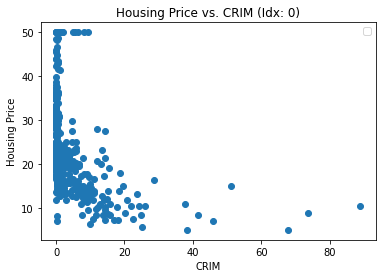

No handles with labels found to put in legend.


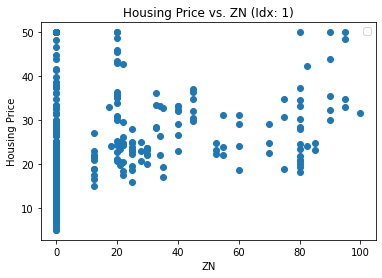

No handles with labels found to put in legend.


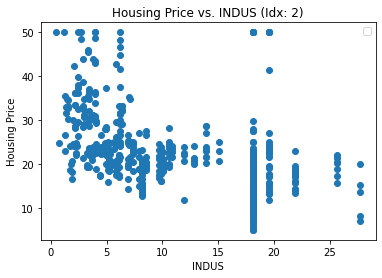

No handles with labels found to put in legend.


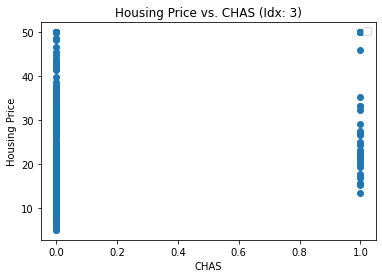

No handles with labels found to put in legend.


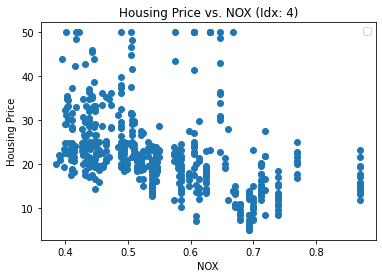

No handles with labels found to put in legend.


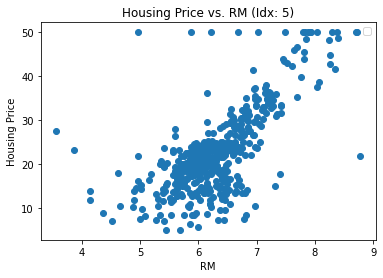

No handles with labels found to put in legend.


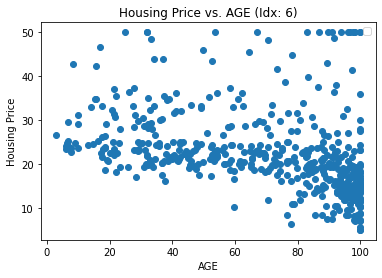

No handles with labels found to put in legend.


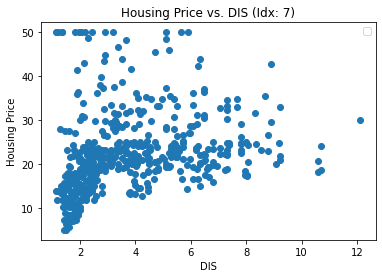

No handles with labels found to put in legend.


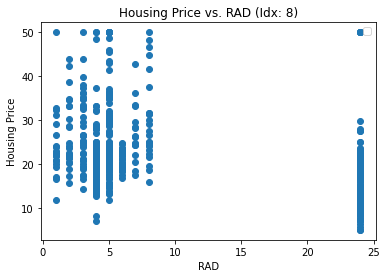

No handles with labels found to put in legend.


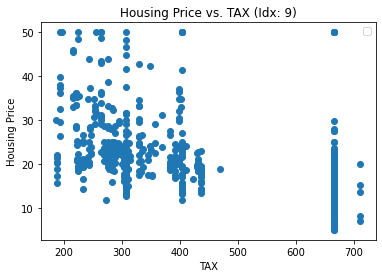

No handles with labels found to put in legend.


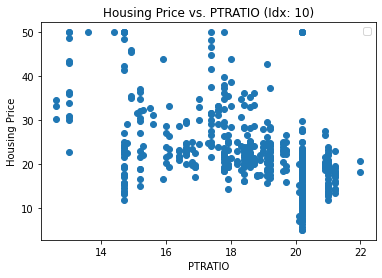

No handles with labels found to put in legend.


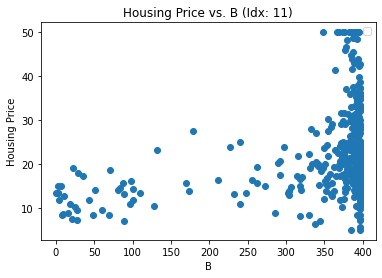

No handles with labels found to put in legend.


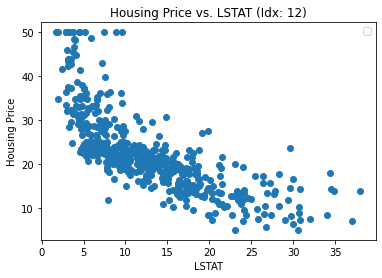

In [3]:
# Investigate features
for feature_index in range(0, 13):
    # Isolate data for plotting
    isolated_name = feature_names[feature_index]
    isolated_X = X_full[:, feature_index]

    # Create plot
    # Plot training data
    plt.scatter(isolated_X, Y)
    plt.xlabel(isolated_name)
    plt.ylabel('Housing Price')
    plt.title('Housing Price vs. %s (Idx: %s)'%(isolated_name, feature_index))
    plt.legend(loc='best')
    # Display plots:
    plt.show()

In [4]:
# Price seems to be correlated to AGE (6) and LSTAT (12)
X = np.stack((X_full[:,6], X_full[:,12]), axis=1)

In [5]:
### Split+shuffle X and Y into k=num_folds different folds:
def KFold_split(X, Y, num_folds, seed):
    KFold_splitter = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    X_train_folds = []
    X_val_folds = []
    Y_train_folds = []
    Y_val_folds = []
    for (kth_fold_train_idxs, kth_fold_val_idxs) in KFold_splitter.split(X, Y):
        X_train_folds.append(X[kth_fold_train_idxs])
        X_val_folds.append(X[kth_fold_val_idxs])
        Y_train_folds.append(Y[kth_fold_train_idxs])
        Y_val_folds.append(Y[kth_fold_val_idxs])
    return X_train_folds, X_val_folds, Y_train_folds, Y_val_folds

In [15]:
### Fit and evaluate a Ridge model with given hyper-parameters:
def assess_Ridge(X_train, X_eval, Y_train, Y_eval, degree, regularization):
    # Build the polynomial features:
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_eval_poly = poly_features.fit_transform(X_eval)
    # Fit the polynomial features with a Ridge model:
    model = Ridge(alpha=regularization)
    # print("\tUsing Regularization: %f"%(regularization))
    model.fit(X_train_poly, Y_train)
    # Evaluate the Ridge model on the evaluation set:
    Y_eval_pred = model.predict(X_eval_poly)
    # MSE = 1/N *SUM((y - predicted)^2)
    # Y_eval_pred = np.asarray(Y_eval_pred)
    # Y_eval = np.asarray(Y_eval)
    # eval_MSE = ((Y_eval - Y_eval_pred)**2).mean()
    eval_MSE = mean_squared_error(Y_eval, Y_eval_pred)
    return eval_MSE

In [19]:
### KFold cross-validation of a Ridge model with given hyper-parameters:
def perform_KFold_CV(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds, degree, regularization):
    val_fold_MSEs = []
    # For each fold, assess a surrogate model with fixed hyper-parameters:
    cmpt = 0
    for X_train_fold, X_val_fold, Y_train_fold, Y_val_fold in zip(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds):
        val_fold_MSE = assess_Ridge(X_train_fold, 
                                    X_val_fold, 
                                    Y_train_fold, 
                                    Y_val_fold, 
                                    degree, regularization)
        cmpt += 1
        print("Surrogate model", str(cmpt) + "/" + str(len(X_val_folds)), "validation MSE:", val_fold_MSE)
        val_fold_MSEs.append(val_fold_MSE)
    # Compute the mean validation MSE between all the folds: 1/n * SUM(MSE_val)
    # mean_val_MSE = (1/cmpt) * sum(val_fold_MSEs)
    mean_val_MSE = np.mean(np.asarray(val_fold_MSEs))
    return mean_val_MSE

In [8]:
### Select a Ridge model on a list of hyper-parameters instances, via Kfold cross-validation:
def KFold_model_selection(X, Y, hyper_parameters_instances, num_folds, seed):
    # Extract a test set:
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, 
                                                                Y, 
                                                                test_size=0.2,
                                                                shuffle=True, 
                                                                random_state=seed)
    # Extract train and validation folds:
    X_train_folds, X_val_folds, Y_train_folds, Y_val_folds = KFold_split(X_train_val, 
                                                                         Y_train_val, 
                                                                         num_folds, 
                                                                         seed)
    # For each hyper-parameter instance, do KFold cross validation:
    mean_val_MSEs = []
    for hyper_parameters_instance in hyper_parameters_instances:
        print("\nNow preprocessing hyper-parameter instance", hyper_parameters_instance)
        degree = hyper_parameters_instance[0]
        regularization = hyper_parameters_instance[1]
        mean_val_MSE = perform_KFold_CV(X_train_folds, 
                                        X_val_folds, 
                                        Y_train_folds, 
                                        Y_val_folds, 
                                        degree, 
                                        regularization)
        print("Mean validation MSE:", mean_val_MSE)
        mean_val_MSEs.append(mean_val_MSE)
    # The hyper-parameter instance with the smallest mean validation MSE is our model of choice:
    best_instance_idx = mean_val_MSEs.index(min(mean_val_MSEs))
    print("BEST INDEX:", best_instance_idx)
    best_hyper_parameters_instance = hyper_parameters_instances[best_instance_idx]
    print("\n\nBest hyper-parameter instance:", best_hyper_parameters_instance)
    # Train the best model on the whole train set then evaluate it on the test set:
    degree2 = best_hyper_parameters_instance[0]
    regularization2 = best_hyper_parameters_instance[1]
    best_model_test_MSE = assess_Ridge(X_train_val, 
                                       X_test, 
                                       Y_train_val, 
                                       Y_test, 
                                       degree2, 
                                       regularization2)
    print("Test MSE:", best_model_test_MSE)

In [20]:
# Perform classification
seed = 666
folds = 5

# Set up hyperparameters
degrees = [1, 2, 3]
regularization_terms = [0, 0.001, 0.01, 0.1]
hyperparameters_input = list(itertools.product(degrees, regularization_terms))

# Perform KFold model selection
KFold_model_selection(X, Y, hyperparameters_input, folds, seed)


Now preprocessing hyper-parameter instance (1, 0)
Surrogate model 1/5 validation MSE: 0.009031246910053647
Surrogate model 2/5 validation MSE: 0.009217820210931957
Surrogate model 3/5 validation MSE: 0.008969429208660527
Surrogate model 4/5 validation MSE: 0.00849181481459341
Surrogate model 5/5 validation MSE: 0.008780899983557662
Mean validation MSE: 0.008898242225559442

Now preprocessing hyper-parameter instance (1, 0.001)
Surrogate model 1/5 validation MSE: 0.009031246760821279
Surrogate model 2/5 validation MSE: 0.009217820311544722
Surrogate model 3/5 validation MSE: 0.008969429438385145
Surrogate model 4/5 validation MSE: 0.008491814629739317
Surrogate model 5/5 validation MSE: 0.008780899975443292
Mean validation MSE: 0.008898242223186751

Now preprocessing hyper-parameter instance (1, 0.01)
Surrogate model 1/5 validation MSE: 0.009031245417765421
Surrogate model 2/5 validation MSE: 0.009217821217081638
Surrogate model 3/5 validation MSE: 0.008969431505923515
Surrogate model 

# Exercise 2 - 1): Choosing the right metrics when dealing with unbalanced data

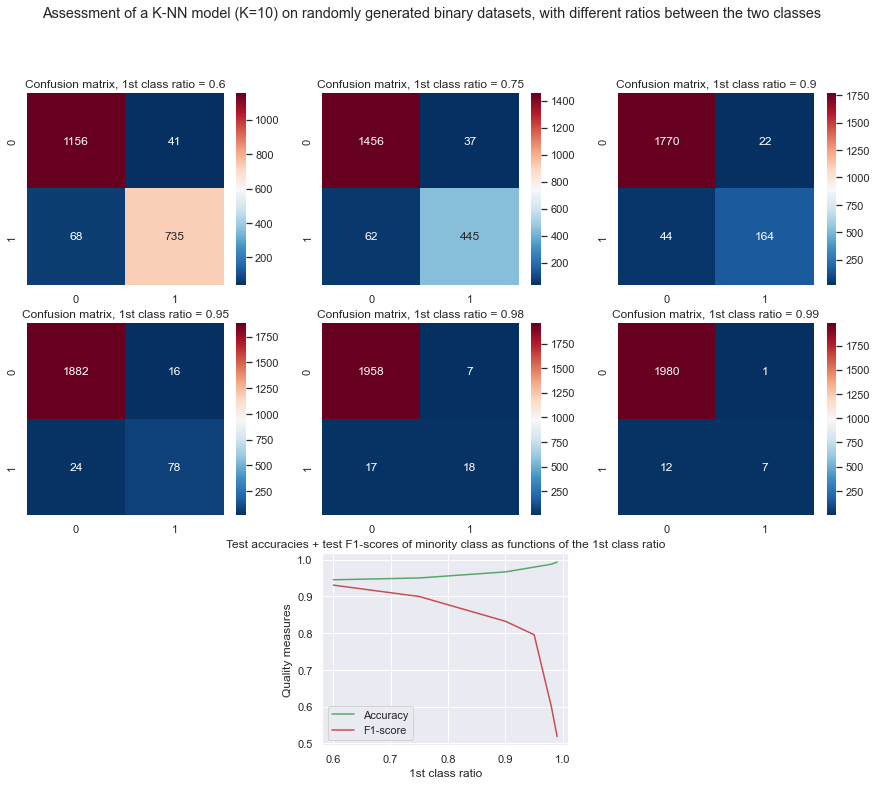

In [10]:
# Fix random seed for reproducibility:
seed = 666
# Set up seaborn (for heatmaps):
sns.set()

### Train and evaluate a K-NN with K=10 on randomly generated binary dataset, with different ratios between 
### the two classes. Use both accuracy and F1 score metrics, plus the confusion matrix:
ratios = [0.6, 0.75, 0.9, 0.95, 0.98, 0.99]
test_accuracies = []
test_f1_scores = []
test_confusion_matrices = []
for ratio in ratios:
    X, Y = make_classification(n_samples=10000, 
                               n_classes=2, 
                               n_features=2, 
                               n_redundant=0, 
                               n_repeated=0, 
                               weights=[ratio],
                               flip_y=0, 
                               random_state=seed)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=seed)
    KNN = KNeighborsClassifier(n_neighbors=10)
    KNN.fit(X_train, Y_train)
    Y_pred = KNN.predict(X_test)
    test_accuracies.append(accuracy_score(Y_test, Y_pred))
    test_f1_scores.append(f1_score(Y_test, Y_pred))
    test_confusion_matrices.append(confusion_matrix(Y_test, Y_pred))
    
    ...

for test_confusion_matrix, ratio, idx in zip(test_confusion_matrices, ratios, range(len(ratios))):
    plt.figure(1, figsize=(15, 12))
    plt.subplot(3, 3, idx+1)
    plt.title("Confusion matrix, 1st class ratio = " + str(ratio))
    sns.heatmap(data=test_confusion_matrix.round(2), annot=True, fmt='d', cmap=sns.color_palette("RdBu_r", 1000))
plt.figure(1)
plt.suptitle("Assessment of a K-NN model (K=10) on randomly generated binary datasets, with different ratios between the two classes")
plt.subplot(3, 3, 8)
plt.title("Test accuracies + test F1-scores of minority class as functions of the 1st class ratio")
plt.plot(ratios, test_accuracies, c='g')
plt.plot(ratios, test_f1_scores, c='r')
plt.legend(["Accuracy", "F1-score"], loc='best')
plt.xlabel('1st class ratio')
plt.ylabel('Quality measures')
plt.show()

# Exercise 2 - 2): Model selection with Kfold cross-validation for classification on unbalanced data

In [11]:
### Split+shuffle X and Y into k=num_folds different folds:
def KFold_split(X, Y, num_folds, seed):
    KFold_splitter = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    X_train_folds = []
    X_val_folds = []
    Y_train_folds = []
    Y_val_folds = []
    for (kth_fold_train_idxs, kth_fold_val_idxs) in KFold_splitter.split(X, Y):
        X_train_folds.append(X[kth_fold_train_idxs])
        X_val_folds.append(X[kth_fold_val_idxs])
        Y_train_folds.append(Y[kth_fold_train_idxs])
        Y_val_folds.append(Y[kth_fold_val_idxs])
    return X_train_folds, X_val_folds, Y_train_folds, Y_val_folds

### Select a model via Kfold cross-validation:
def KFold_model_selection(X, Y, models, num_folds, seed):
    ...

### KFold cross-validation of a model:
def perform_KFold_CV(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds, ...):
    ...

### Fit and evaluate a model:
def assess_model(X_train, X_eval, Y_train, Y_eval, ...):
    ...

SyntaxError: invalid syntax (Temp/ipykernel_16708/430414977.py, line 20)

No handles with labels found to put in legend.


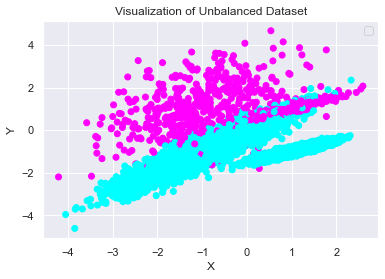

In [ ]:
### Model selection of a classification model on unbalanced data with KFold cross-validation:
# Load an unbalanced binary dataset:
with open('HW3_custom_unbalanced_dataset.pickle', 'rb') as unbalanced_dataset:
    X2, Y2 = pickle.load(unbalanced_dataset)
    
    # Visualize Dataset
    plt.scatter(X2[:,0],X2[:,1], c=Y, cmap=plt.cm.cool)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Visualization of Unbalanced Dataset')
    plt.legend(loc='best')
    # Display plots:
    plt.show()
    
    # Models to be cross-validated:
    models = {0: "K-NN",
              1: "Logistic regression",
              2: "Decision Tree"}
    # Select model with KFold cross-validation (use > 5 folds):
    ...